<a href="https://colab.research.google.com/github/Ogunfool/Multi-class-logistic-regression-with-Python./blob/main/MNIST_datset_with_other_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

In [ ]:
train_load = np.loadtxt("mnist_train_small.csv", delimiter = ",")
test_load = np.loadtxt("mnist_test.csv", delimiter = ",")

In [ ]:
print(train_load.shape, test_load.shape)

(20000, 785) (10000, 785)


In [ ]:
X_train , y_train = train_load[:,1:], train_load[:,0]
X_test , y_test = test_load[:,1:], test_load[:,0]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(type(train_load))
print(type(test_load))

In [ ]:
# Normalize data
data_normalize = StandardScaler()
X_train_norm = data_normalize.fit_transform(X_train)
X_test_norm = data_normalize.transform(X_test)

In [ ]:
# print(X_train_norm, X_test_norm)

In [ ]:
# Observation: Don't call your data X_train and X_test yet till you load, clean, preprocess
# (Just do all the transformations necessary and it is ready for use)
X_train = X_train_norm
X_test = X_test_norm

Trying 3 different models (DecisionTree, Logistic Regression, KNeighbors Classifier).

In [ ]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier()}

results = []
for model in models.values():
  KF = KFold(n_splits = 5, random_state=42, shuffle=True)
  cv_results = cross_val_score(model,X_train,y_train,cv=KF)
  results.append(cv_results)
print("Model Selection Results_No pipeline:", results)
plt.boxplot(results, labels=models.keys())
plt.show()


In [ ]:
#  From the box plot, we can see that KNN is doing better on the validation set.
#  So we optimize it further.
average_scores = []
for n in results:
  average_scores.append(np.mean(n))
print(average_scores)

[0.88795, 0.92235, 0.8280999999999998]


In [ ]:
# Lets see how KNN behaves on the test set
for name, model in models.items():
  model.fit(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print("{} Test Set Accuracy: {}".format(name, test_score))

PART B - Logistic regression on full MNIST dataset

In [ ]:
%%time
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

CPU times: user 29.3 s, sys: 2.48 s, total: 31.8 s
Wall time: 47.9 s


In [ ]:
type(mnist.data), type(mnist.categories), type(mnist.feature_names), type(mnist.target)

(pandas.core.frame.DataFrame, NoneType, list, pandas.core.series.Series)

In [ ]:
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

In [ ]:
Xtemp_train, X_test, ytemp_train, y_test = train_test_split(mnist.data, 
                                                    mnist.target.astype('int'), #targets str to int convert
                                                   test_size=1/7.0,
                                                   random_state=0)

In [ ]:
# Set shuffle to true to shuffle before split
X_train, X_val, y_train, y_val = train_test_split(Xtemp_train, ytemp_train, test_size = 0.2, random_state = 42, shuffle=True)

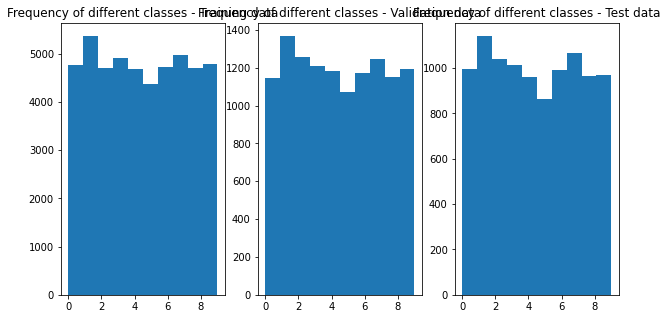

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.hist(y_train);
plt.title('Frequency of different classes - Training data');

plt.subplot(1,3,2)
plt.hist(y_val);
plt.title('Frequency of different classes - Validation data');

plt.subplot(1,3,3)
plt.hist(y_test);
plt.title('Frequency of different classes - Test data');

In [ ]:
# Let's normalize data - StandardScaler
# Fit t0 training set and use mean and std to transform X_train and X_test
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

(48000, 784) (12000, 784) (10000, 784)



1.   The sklearn.linear_model.LogisticRegression solver, SAGA - Stochastic Average Gradient descent does not need learning rate.



In [ ]:
log_reg_classifier = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l2', #Ridge regression
                        solver='saga',
                        max_iter=200,
                        C=1000,
                        verbose=2, # output progress
                        n_jobs=5, # parallelize over 5 processes
                        tol=0.001
                         )
log_reg_classifier

LogisticRegression(C=1000, max_iter=2000, n_jobs=5, solver='saga', tol=0.001,
                   verbose=2)

In [ ]:
%%time
log_reg_classifier.fit(X_train_scaled, y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 525 epochs took 1194 seconds
CPU times: user 18min 58s, sys: 1.19 s, total: 19min
Wall time: 19min 54s


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed: 19.9min finished


LogisticRegression(C=1000, max_iter=2000, n_jobs=5, solver='saga', tol=0.001,
                   verbose=2)

In [ ]:
log_reg_classifier.score(X_train_scaled, y_train)

0.9355

In [ ]:
log_reg_classifier.score(X_val_scaled, y_val)

0.9243333333333333

Let's select our model using cross validation and Gridsearch - GridCV in Sklearn. Note that after choosing the best hyperparameters, the CV models are discarded and the final model is trained with those hyperparameters.



In [ ]:
KF = StratifiedKFold(n_splits = 3, random_state=42, shuffle=True)
param_grid = {'penalty':['l2'],
              'C': [1000,100,10],}
# Model
log_reg = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        # penalty='l2', #Ridge regression
                        solver='saga',
                        max_iter=400,
                        verbose=2, # output progress
                        n_jobs=8, # parallelize over 5 processes
                        tol=0.01
                         )
log_reg_GridCV = GridSearchCV(log_reg, param_grid, cv= KF)

In [ ]:
log_reg_GridCV.fit(X_train_scaled, y_train)

In [ ]:
log_reg_GridCV.get_params().keys()

In [ ]:
log_reg_GridCV.best_params_

{'C': 10, 'penalty': 'l2'}

In [ ]:
log_reg_GridCV.best_score_

0.90645

Now train final model

In [ ]:
log_reg_classifier = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l2', #Ridge regression
                        solver='saga',
                        max_iter=2000,
                        C=10,
                        verbose=2, # output progress
                        n_jobs=5, # parallelize over 5 processes
                        tol=0.001
                         )
log_reg_classifier

LogisticRegression(C=10, max_iter=2000, n_jobs=5, solver='saga', tol=0.001,
                   verbose=2)

In [ ]:
%%time
log_reg_classifier.fit(X_train_scaled, y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 512 epochs took 1278 seconds
CPU times: user 21min 19s, sys: 784 ms, total: 21min 19s
Wall time: 21min 18s


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed: 21.3min finished


LogisticRegression(C=10, max_iter=2000, n_jobs=5, solver='saga', tol=0.001,
                   verbose=2)

In [ ]:
log_reg_classifier.score(X_test_scaled, y_test)

0.9188